In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import numpy.random as rand
rndm = np.random.RandomState(12345)

In [2]:
eps = 0.1       #Шаг во времени
N = 100       #Число разбиений
lam = 2.       #Лямбда
delta = 1.1       #Дельта из Розенфельдера
nInner = 3       #Число случайных реализаций перед поворотом
nTherm = 1000       #Необходимое число шагов до термализации
xIn = 0.5*np.ones(N)       #Начальная реализация пути
nMean = 1000       #Число путей для усреднения
nUncorr = 30       #Число изменений для того, чтобы реализации были нескоррелированные

In [3]:
def deltaS(i,xN,xO):       #Изменение действия для i-го x при выборе изменении пути
    if i==0:   #Периодические гран условия
        dS = (xN-xO[i]) * (
        (1/eps+eps/2+eps * lam*(
            xN**2 + xO[i]**2
            )
        )*(xN+xO[i])-1/eps*(
        xO[(i+1)]+xO[-2]       #Требую, чтобы -1 соответствовал N-1
        ))
    elif i == N-1:
        dS = (xN-xO[i]) * (
        (1/eps+eps/2+eps * lam*(
            xN**2 + xO[i]**2
            )
        )*(xN+xO[i])-1/eps*(
        xO[1]+xO[i-1]       #Требую, чтобы N+1 соответствовал 1
        ))
    else:
        dS = (xN-xO[i]) * (
            (1/eps+eps/2+eps * lam*(
                xN**2 + xO[i]**2
                )
            )*(xN+xO[i])-1/eps*(
            xO[(i+1)]+xO[i-1]  
            ))
    return dS

In [4]:
def step(xx):
    xArr = np.copy(xx)
    for i in range(0,N):
        for _ in range(0,nInner):
            z1 = rndm.uniform()       #Случайные числа для реализации шага
            z2 = rndm.uniform()
            xNew = xArr[i] + delta*(z1-0.5)
            if np.exp(-deltaS(i,xNew,xArr))>z2 or deltaS(i,xNew,xArr)<0:        #Вероятностное изменение x_i
                xArr[i] = xNew
                if i == 0:
                    xArr[-1] = xNew
                if i == N-1:
                    xArr[0] = xNew
    return (xArr, xx)

In [5]:
def therm(xx):
    xCur = np.copy(xx)
    for _ in range (0,nTherm):       #Изменение реализации столько раз, чтобы она забыла про начальные условия
        xCur, xPrev = step(xCur)
    return (xCur,xPrev)

In [6]:
def e(x):       #Энергия с учётом вириальной теоремы
    return np.mean(x**2 + 3*lam*x**4)

In [7]:
def compute(xx):
    xSet,_ = therm(xx)      #Термализованная реализация
    enSet = np.empty(0)
    pathSet = np.empty([N,nMean])
    for j in range(0,nMean):
        for _ in range(0,nUncorr):
            xSet, _ = step(xSet)      #Конкретный путь
        enSet = np.append(enSet,e(xSet))
        pathSet[:,j] = xSet
        print(j/nMean, end='\r')
    return (enSet, pathSet)

In [8]:
def corrFuncT(pathSet1):     #Определяю корреляционную функцию как среднее \sum_j \mean{x_{j+t},x_{j}}
    corrF = np.zeros(N)
    for n in range(0,N):
        arr = np.zeros(N-n)
        for j in range(0,N-n):
            arr[j] = np.mean(pathSet1[j,:]*pathSet1[j+n,:])
        corrF[n] = np.mean(arr)
    return corrF

def corrTime(pathSet1):     #Определяю корр время как время, за которое корр функция затухает в E раз
    return np.min(np.arange(N)[corrFuncT(pathSet1)<corrFuncT(pathSet1)[0]/np.exp(1)])*eps

In [9]:
def binning(nSize, arr):    #Функция для стохастических ошибок после многих усреднений
    partAv = np.zeros(0)
    for i in range(0,len(arr),nSize):
        el = 0
        for j in range(i,i+nSize):
            el += 1/nSize*arr[j%N]
        partAv = np.append(partAv,el)
#        print(len(partAv))
    return partAv



In [10]:
def ranTake(enAr):
    ar = np.zeros(0)
    for _ in range(0,len(enAr)):
        ar = np.append(ar,enAr[rndm.randint(0,len(enAr))])
    return ar

def statErr(enAr,nShuffle=20): #Создаю больше реализаций из исходной, считая их независимыми и перемешивая, воссоздавая исходное распределение, считая общую дисперсию
    arbArr = np.zeros(0)
    for i in range(0,nShuffle):
        arbArr = np.append(arbArr,np.mean(ranTake(enAr)))
    return (np.mean(arbArr**2)-np.mean(arbArr)**2)

def binStatErr(arrEn):   #При биннинге избавиться от корреляций, вовремя останавливаясь
    i = 4
    varArr = np.array([0,(np.mean(arrEn**2)-np.mean(arrEn)**2)])
    difArr = np.zeros(0)
    while i<int(nMean):
        asd11 = binning(int(nMean/i),arrEn)
        varArr[0] = (np.mean(asd11**2)-np.mean(asd11)**2)
        difArr = np.append(difArr,((varArr[0]-varArr[1])/varArr[0]))
        if len(difArr)>2 and abs(difArr[-1]-difArr[-2])<0.1: #Останавливаюсь, если относительная дисперсия перестаёт меняться
            sysErr = varArr[1]
            break
        i *=2
        varArr[1] = varArr[0]
    return varArr[1]

In [11]:
enComp, pathComp = compute(xIn)

In [12]:
errSt = statErr(enComp)
errStBin = binStatErr(enComp)
gr_en = np.mean(enComp)
time = corrTime(pathComp)


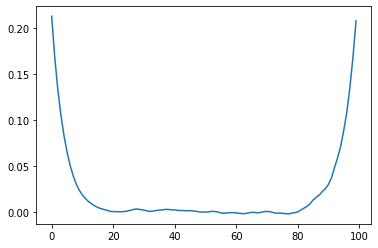

In [13]:
plt.plot(corrFuncT(pathComp))

In [14]:
N = 50
eps=0.2
enComp1, pathComp1 = compute(xIn[:50])

In [15]:
errSt1 = statErr(enComp1)
#errSt1Bin = binStatErr(enComp1)-errSyst1
gr_en1 = np.mean(enComp1)
errSYSTEM1 = abs(errSt-errSt1)
#errSYSTEM2 = abs(errStBin-errSt1Bin)

In [16]:
print("Energy = {:.4f};\nCorrelation Time = {:.4f};\nSystematic Error = {:.4f};\nStochastic Error = {:.4f};"
      .format(gr_en, time, errSYSTEM1**0.5, errSt**0.5))

Energy = 0.9419;
Correlation Time = 0.5000;
Systematic Error = 0.0063;
Stochastic Error = 0.0109;


In [17]:
print("Energy from matrix 150x150 matrix= 0.951568")

Energy from matrix 150x150 matrix= 0.951568


In [18]:
"""
Ничего более умного для измерения порядка систематической ошибки, 
кроме как изменения размера система и вычитания разностей ошибок я не придумал

Те ошибки, которые не принтятся в принципе хуже потому что недостаточно большое число выборки при биннинге
"""

'\nНичего более умного для измерения порядка систематической ошибки, \nкроме как изменения размера система и вычитания разностей ошибок я не придумал\n\nТе ошибки, которые не принтятся в принципе хуже потому что недостаточно большое число выборки при биннинге\n'